In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Settings
n_samples = 50
n_train = 40
n_test = 10
noise = .5  # Standard deviation of the noise
np.random.seed(42)

def f(x):
    return (x - 1)**2

xlim = [0,2]
ylim = [0,1]

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * xlim[1]
    X = np.sort(X)
    Y = np.random.normal(f(X), noise, n_samples)
    return X, Y

X_ideal, Y_ideal = generate(n_samples=200, noise=0.0)
X, Y = generate(n_samples=n_samples, noise=noise)

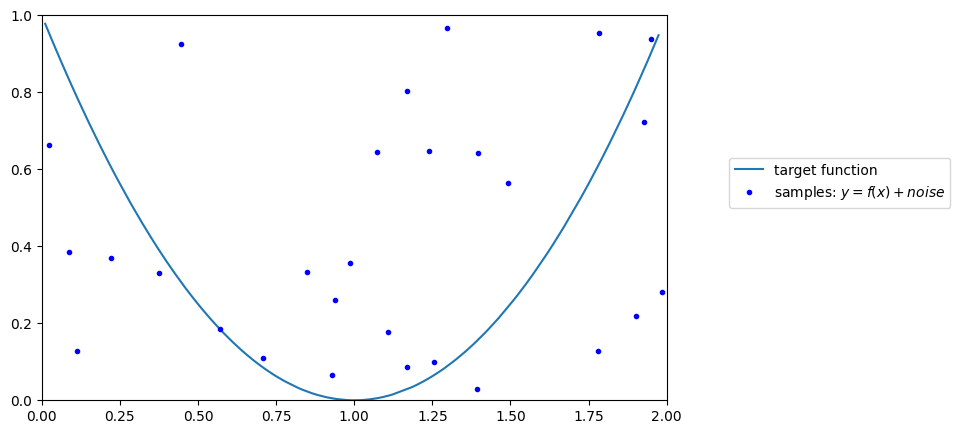

In [3]:
plt.figure(figsize=(10, 5))

# Plot f
plt.plot(X_ideal, Y_ideal, label="target function")

# Plot X, Y
plt.plot(X, Y, ".b", label="samples: $y = f(x)+noise$")

plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(loc=(1.1, 0.5))

plt.subplots_adjust(right=0.75)
plt.show()

## Learning polynomials: the kernel method

The first thing we learned was **least square multivariate linear regression**: 
* **regression** means that we are trying to learn a function $f : X \to \mathbb{R}$
* **multivariate** means that $X = \mathbb{R}^d$ for some dimension $d \ge 1$
* **linear** means that we consider linear models (of the corresponding dimension): $h(x) = x @ W$ with $W \in \mathbb{R}^d$
* **least square** means that the (training) loss we consider is $$\mathcal{L}(h) = \sum_{i = 1}^n (h(x_i) - y_i)^2$$ where $(x_i,y_i)_{i = 1,\dots,n}$ is the training data.

Now we show how to use least square multivariate regression to learn polynomials:
* we are still doing regression, but over a single variable: $X = \mathbb{R}$, so we are trying to learn a function $f : \mathbb{R} \to \mathbb{R}$
* but the class of models is polynomials of degree $d$, meaning $h(x) = \sum_{i = 0}^d a_i x^i$ where $a_i \in \mathbb{R}$ (note that $h : \mathbb{R} \to \mathbb{R}$)

The idea is simple: starting from $x \in \mathbb{R}$, we build the vector $\mathbf{x} = (x_i^d , x_{i}^{d-1} , \dots , x_{i}, 1)$, and we use least sqaure multivariate linear regression over the dataset $(\mathbf{x}_i, y_i)_{i = 1,\dots,n}$ to learn a function $\mathbf{h} : \mathbb{R}^{d+1} \rightarrow \mathbb{R}$.

Why does it work? Simply because
$$\mathbf{h}(\mathbf{x}) = \mathbf{x} @ W = \sum_{i = 0}^d a_i x^i = h(x)$$
where $W = (a_d,\dots,a_1,a_0)$, and the loss becomes
$$\mathcal{L}(\mathbf{h}) = \sum_{i = 1}^n (\mathbf{h}(\mathbf{x}_i) - y_i)^2 = \sum_{i = 1}^n (h(x_i) - y_i)^2 = \mathcal{L}(h)$$

In [13]:
# This illustrates how vander function works:
x1 = np.array([1,2,3])
x1, np.vander(x1, 4)

(array([1, 2, 3]),
 array([[ 1,  1,  1,  1],
        [ 8,  4,  2,  1],
        [27,  9,  3,  1]]))

In [14]:
def fit_polynomial(X, Y, degree):
    '''
    Fits a polynomial to the input sample.
    (X,Y): input sample
    degree: polynomial degree
    '''
    model = LinearRegression()
    model.fit(np.vander(X, degree + 1), Y)
    return model

def apply_polynomial(model, X):
    '''
    Evaluates a linear regression model on an input sample
    model: linear regression model
    X: input sample
    '''
    degree = model.coef_.size - 1
    Y = model.predict(np.vander(X, degree + 1))
    return Y

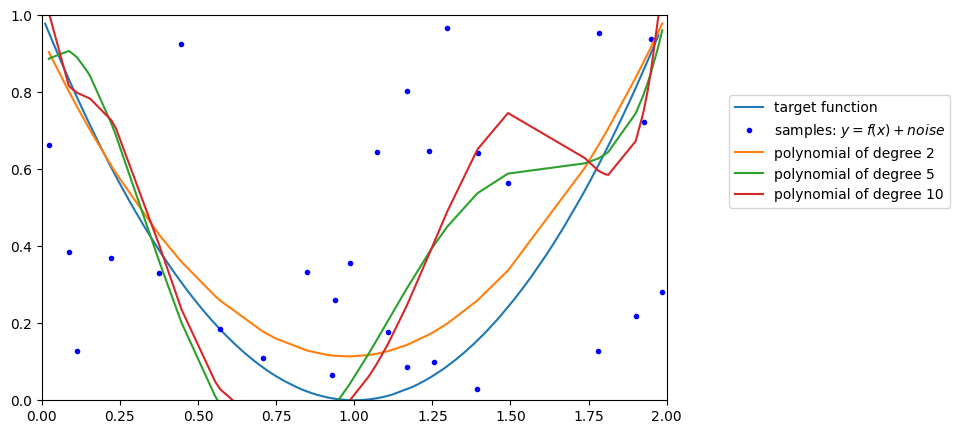

In [91]:
plt.figure(figsize=(10, 5))

# Plot f
plt.plot(X_ideal, Y_ideal, label="target function")

# Plot training data (the first one)
plt.plot(X, Y, ".b", label="samples: $y = f(x)+noise$")

def fit_plot(degree):
    model = fit_polynomial(X, Y, degree)
    Y_predicted = apply_polynomial(model, X)
    plt.plot(X, Y_predicted, label="polynomial of degree " + str(degree))

fit_plot(2)
fit_plot(5)
fit_plot(10)
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(loc=(1.1, 0.5))

plt.subplots_adjust(right=0.75)
plt.show()

## Model selection

Here is a wrong approach:

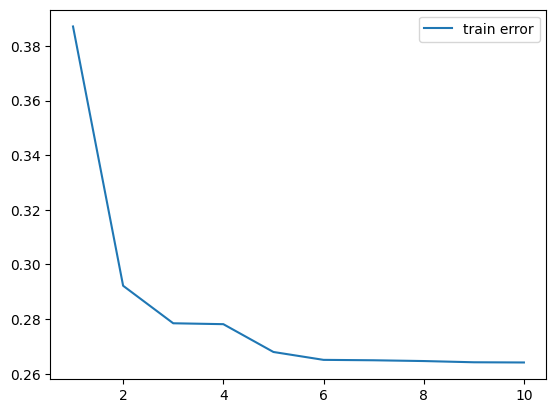

In [92]:
max_degree = 10
train_error_vals = []
for degree in range(1, max_degree+1):
    model = fit_polynomial(X, Y, degree)

    Y_predicted = apply_polynomial(model, X)
    train_error_vals.append(np.linalg.norm(Y - Y_predicted)**2 / n_samples)

plt.plot(range(1, max_degree+1), train_error_vals, label='train error')
plt.legend();

Issue: always picks to model with highest bias, because it fits best the training data, but may not generalise too well

## Model selection via hold out cross validation

Idea: we divide between training and validation set

In [93]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=n_test, random_state=0)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((40,), (10,), (40,), (10,))

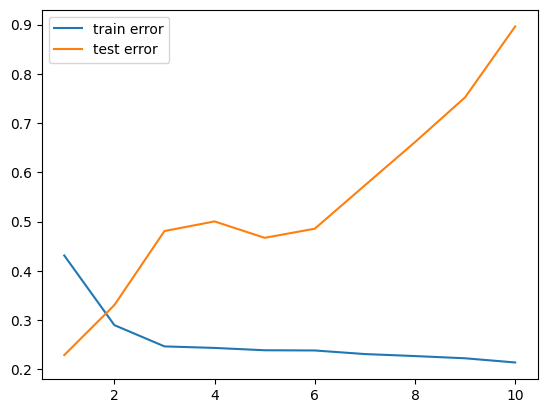

In [94]:
max_degree = 10
train_error_vals = []
test_error_vals = []
for degree in range(1, max_degree+1):
    model = fit_polynomial(X_train, Y_train, degree)

    Y_predicted_train = apply_polynomial(model, X_train)
    train_error_vals.append(np.linalg.norm(Y_train - Y_predicted_train)**2 / n_train)

    Y_predicted_test = apply_polynomial(model, X_test)
    test_error_vals.append(np.linalg.norm(Y_test - Y_predicted_test)**2 / n_test)

plt.plot(range(1, max_degree+1), train_error_vals, label='train error')
plt.plot(range(1, max_degree+1), test_error_vals, label='test error')
plt.legend();

Issue: wastes a lot of the data because it holds it out for test

## Model selection via k-fold cross validation

In [95]:
from sklearn.model_selection import KFold

n_splits = max_degree = 10
n_test = int(n_samples / n_splits)
n_train = int(n_samples / n_splits * (n_splits - 1))

kf = KFold(n_splits=n_splits)
X_train = np.zeros((n_splits, n_train))
X_test = np.zeros((n_splits, n_test))
Y_train = np.zeros((n_splits, n_train))
Y_test = np.zeros((n_splits, n_test))
for i, (train, test) in enumerate(kf.split(X)):
    X_train[i,:], X_test[i,:], Y_train[i,:], Y_test[i,:] = X[train], X[test], Y[train], Y[test]
    print("%s %s" % (train.shape, test.shape))

(45,) (5,)
(45,) (5,)
(45,) (5,)
(45,) (5,)
(45,) (5,)
(45,) (5,)
(45,) (5,)
(45,) (5,)
(45,) (5,)
(45,) (5,)


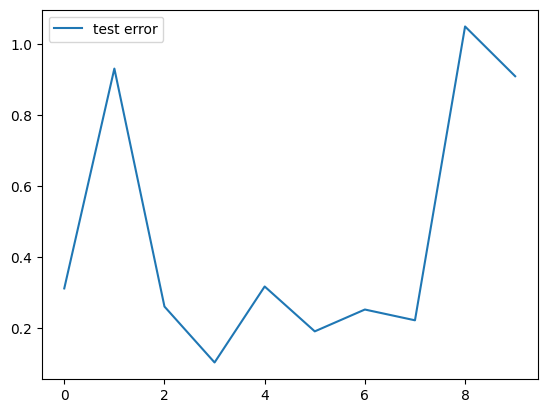

In [96]:
test_error_vals = []
for degree in range(max_degree):
    model = fit_polynomial(X_train[degree, :], Y_train[degree, :], degree)
    Y_predicted = apply_polynomial(model, X_test[degree, :])
    test_error_vals.append(np.linalg.norm(Y_test[degree, :] - Y_predicted)**2 / n_test)

plt.plot(range(max_degree), test_error_vals, label='test error')
plt.legend();